# Oil Spill Detection – Data Preprocessing & Visualization

This notebook covers:
- Dataset loading
- Data preprocessing and augmentation
- Class imbalance analysis
- Visualization of images and masks
- Validation of preprocessing pipeline

The goal is to ensure the data is **clean, balanced, and model-ready** before training.


In [1]:
import cv2
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
import random


In [2]:
TARGET_SIZE = (640, 640)
NUM_CLASSES = 6

CLASS_NAMES = [
    "Background",
    "Emulsion",
    "Oil",
    "Oil-Platform",
    "Sheen",
    "Ship"
]

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

IMG_EXTENSIONS = [".jpg", ".jpeg", ".png"]


## Data Augmentation Strategy

Augmentations are carefully selected to:
- Preserve aerial geometry
- Improve generalization
- Avoid unrealistic transformations


In [3]:
train_transforms = A.Compose([
    A.Resize(*TARGET_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.4),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=0,
        p=0.4
    ),
    A.RandomBrightnessContrast(p=0.4),
    A.GaussianBlur(blur_limit=3, p=0.15),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transforms = A.Compose([
    A.Resize(*TARGET_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## Dataset Loader

- Supports Roboflow segmentation format
- Loads image–mask pairs
- Applies joint augmentation


In [4]:
class OilSpillDataset(Dataset):
    def __init__(self, root_dir, split="train", transforms=None):
        self.root = Path(root_dir) / split
        self.transforms = transforms

        self.images = sorted([
            p for p in self.root.iterdir()
            if p.suffix.lower() in IMG_EXTENSIONS and "_mask" not in p.name
        ])

        if len(self.images) == 0:
            raise RuntimeError(f"No images found in {self.root}")

        print(f"[{split.upper()}] {len(self.images)} samples loaded")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = img_path.with_name(img_path.stem + "_mask.png")

        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = np.array(Image.open(mask_path), dtype=np.int64)

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        image = torch.from_numpy(image).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).long()

        return image, mask


## Dataset Initialization


In [5]:
ROOT = "/kaggle/input/oil-spill-raw-segmentation"

train_ds = OilSpillDataset(ROOT, "train", train_transforms)
val_ds   = OilSpillDataset(ROOT, "valid", val_transforms)


[TRAIN] 2370 samples loaded
[VALID] 675 samples loaded


## Class Imbalance Analysis

Oil spill datasets are highly imbalanced.
We compute pixel-wise class weights to address this issue.


In [6]:
def compute_class_weights(dataset):
    counts = np.zeros(NUM_CLASSES, dtype=np.int64)

    for _, mask in tqdm(dataset, desc="Computing class weights"):
        ids, freqs = np.unique(mask.numpy(), return_counts=True)
        for i, f in zip(ids, freqs):
            if i < NUM_CLASSES:
                counts[i] += f

    freq = counts / counts.sum()
    weights = 1.0 / (np.sqrt(freq) + 1e-6)
    weights = weights / weights.mean()

    return torch.tensor(weights, dtype=torch.float32)

class_weights = compute_class_weights(train_ds)

for i, w in enumerate(class_weights):
    print(f"{CLASS_NAMES[i]}: {w:.4f}")


Computing class weights: 100%|██████████| 2370/2370 [01:34<00:00, 25.01it/s]

Background: 0.1274
Emulsion: 0.2103
Oil: 0.1953
Oil-Platform: 4.3912
Sheen: 0.2451
Ship: 0.8307


## Dataset Statistics Visualization


Background: 52.87%
Emulsion: 20.62%
Oil: 25.03%
Oil-Platform: 0.00%
Sheen: 0.00%
Ship: 1.48%


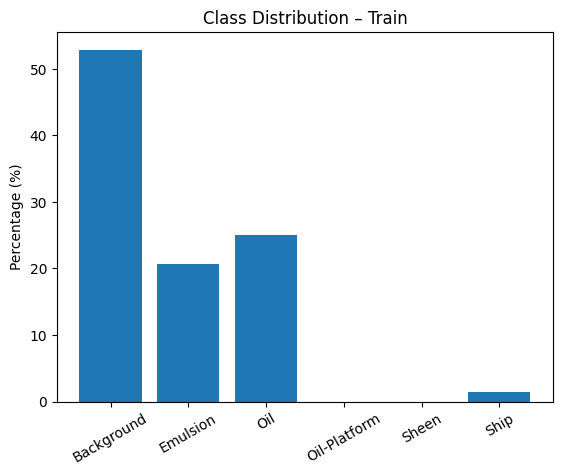

Background: 46.17%
Emulsion: 18.42%
Oil: 22.25%
Oil-Platform: 0.08%
Sheen: 12.05%
Ship: 1.03%


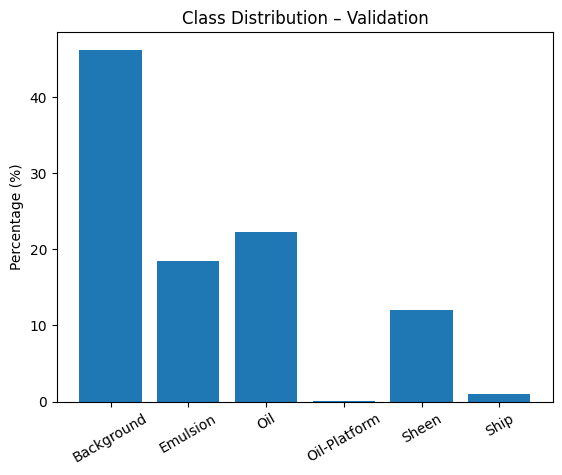

In [7]:
def summarize_dataset(dataset, split_name, n_samples=None):
    counts = np.zeros(NUM_CLASSES)

    if n_samples is None:
        n_samples = len(dataset)

    for i in range(n_samples):
        _, mask = dataset[i]
        ids, freqs = np.unique(mask.numpy(), return_counts=True)
        for cid, cnt in zip(ids, freqs):
            counts[cid] += cnt

    total = counts.sum()
    for i in range(NUM_CLASSES):
        print(f"{CLASS_NAMES[i]}: {counts[i]/total*100:.2f}%")

    plt.bar(CLASS_NAMES, counts / total * 100)
    plt.xticks(rotation=30)
    plt.ylabel("Percentage (%)")
    plt.title(f"Class Distribution – {split_name}")
    plt.show()

summarize_dataset(train_ds, "Train", n_samples=50)
summarize_dataset(val_ds, "Validation")


## Visual Inspection of Preprocessed Samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


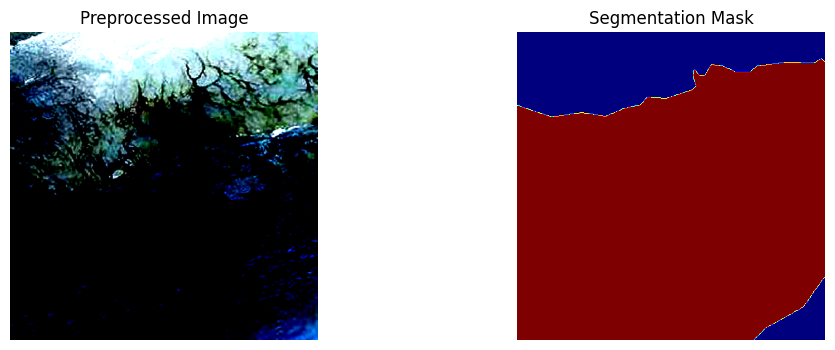

In [8]:
def visualize_sample(dataset, idx):
    img, mask = dataset[idx]
    img = img.permute(1,2,0).numpy()

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Preprocessed Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask, cmap="jet")
    plt.title("Segmentation Mask")
    plt.axis("off")

    plt.show()

visualize_sample(train_ds, random.randint(0, len(train_ds)-1))


## Summary

- Dataset integrity verified
- Augmentations validated
- Class imbalance analyzed
- Preprocessing pipeline ready for model training
